<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [2]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
import os
import pandas as pd
import skimage
from skimage.transform import rescale, resize
%matplotlib inline

In [22]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
# from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
from torch.utils.data import DataLoader, random_split

In [ ]:
train_size = int(0.8 * len(data))
val_size = len(data) - train_size
train_dataset, val_dataset = random_split(data, [train_size, val_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

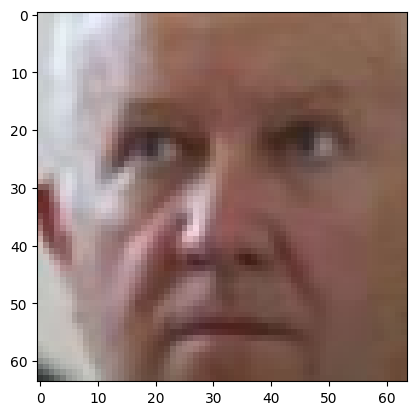

In [ ]:
plt.imshow(train_dataset[0])

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [25]:
dim_code = 5 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
dataiter = iter(train_loader)
images = next(dataiter)

In [ ]:
images[0].shape

torch.Size([64, 64, 3])

In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self, hiden_dim):
        super().__init__()
        # self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=64*64*8, out_features=hiden_dim)
        )

        self.linear = nn.Linear(in_features=hiden_dim, out_features=64*64*8)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(16, 32, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=7, stride=1, padding=3),
            nn.Sigmoid()
        )
        # self.encoder = nn.Sequential(
        #     nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        #     nn.ReLU()
        # )
        # self.decoder = nn.Sequential(
        #     nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
        #     nn.Sigmoid()  # Применяем сигмоид для получения значений от 0 до 1
        # )

    def forward(self, x):

        latent_code = self.encoder(x)
        x = self.linear(latent_code)
        reconstruction = self.decoder(x.view(-1, 8, 64, 64))

        return reconstruction, latent_code

In [26]:
n_epochs = 50
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = Autoencoder(dim_code).to(device)
criterion = F.mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [7]:
from tqdm import tqdm_notebook

In [28]:
train_losses = []
val_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        optimizer.zero_grad()
        b = X_batch.float().permute(0, 3, 1, 2)
        reconstructed, latent_code = model(b.to(device))
        loss = criterion(reconstructed, b.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
          reconstructed, latent_code = model(X_batch.float().permute(0, 3, 1, 2).to(device))
          loss = criterion(reconstructed, X_batch.float().permute(0, 3, 1, 2).to(device))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

<ipython-input-28-32bdf919f923>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/50 [00:00<?, ?it/s]

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [29]:
dataiter = iter(val_loader)
images = next(dataiter)
reconstructed, latent_code = model(images.float().permute(0, 3, 1, 2).to(device))

In [30]:
reconstructed.permute(0, 2, 3, 1).cpu().detach().numpy()[0].shape

(64, 64, 3)

In [31]:
img = reconstructed.permute(0, 2, 3, 1).cpu().detach().numpy()[0]

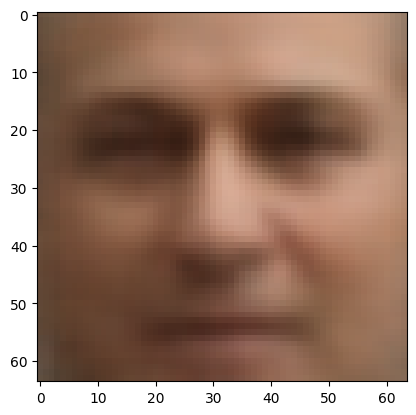

In [32]:
plt.imshow(img)



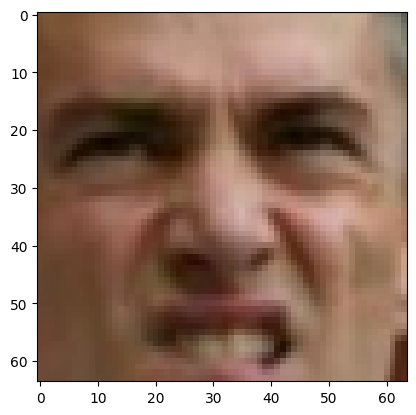

In [33]:
plt.imshow(images[0])

Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

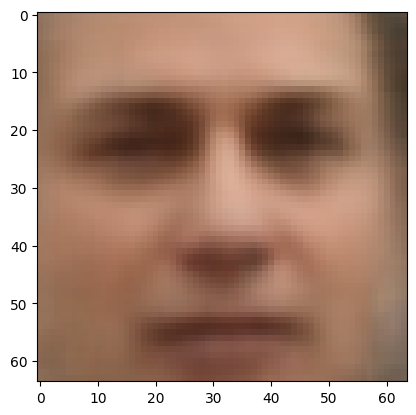

In [38]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, dim_code)
output = model.decoder(model.linear(torch.tensor(z).float().to(device)).view(-1, 8, 64, 64))
output = output.permute(0, 2, 3, 1).cpu().detach().numpy()
plt.imshow(output[0])

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [3]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 70949765.60it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 17681461.66it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 20387268.06it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3928754.13it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [52]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста",
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        self.features = 10

        self.flatten = nn.Flatten()

        self.encoder = nn.Sequential(
            nn.Linear(in_features=784, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=self.features*2)
        )

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=784)
        )

    def encode(self, x):

        x = self.encoder(x).view(-1, 2, self.features)
        mu = x[:, 0, :] # the first feature values as mean
        logsigma = x[:, 1, :]

        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)

        return reconstruction.view(-1, 1, 28, 28)

    def forward(self, x):
        x = self.flatten(x).float()
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)

        reconstruction = self.decode(z)

        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [58]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = F.binary_cross_entropy(reconstruction, x, reduction='sum')
    return loss

def loss_vae(x, mu, logsigma, reconstruction):
    kl_loss = KL_divergence(mu, logsigma)
    recon_loss = log_likelihood(x, reconstruction)
    total_loss = kl_loss + recon_loss
    return total_loss

И обучим модель:

In [59]:
criterion = loss_vae

model = VAE()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [60]:
dataiter = iter(train_loader)
images = next(dataiter)

In [61]:
images[0].shape

torch.Size([32, 1, 28, 28])

In [64]:
train_losses = []
val_losses = []

n_epochs=20

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

for epoch in tqdm_notebook(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        optimizer.zero_grad()
        mu, logsigma, reconstruction  = model(X_batch[0].to(device))
        loss = criterion(X_batch[0].to(device), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in test_loader:
          mu, logsigma, reconstruction = model(X_batch[0].to(device))
          loss = criterion(X_batch[0].to(device), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

<ipython-input-64-85e5185bc8eb>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/20 [00:00<?, ?it/s]

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [86]:
dataiter = iter(test_loader)
images = next(dataiter)

mu, logsigma, reconstruction = model(images[0].to(device))

index = 13

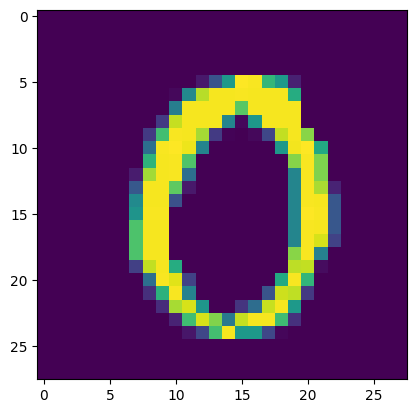

In [87]:
plt.imshow(images[0][index].permute(1, 2, 0).numpy())

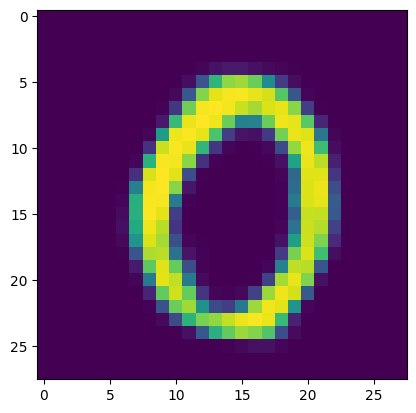

In [88]:
output = reconstruction[index].permute(1, 2, 0).detach().numpy()
plt.imshow(output)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

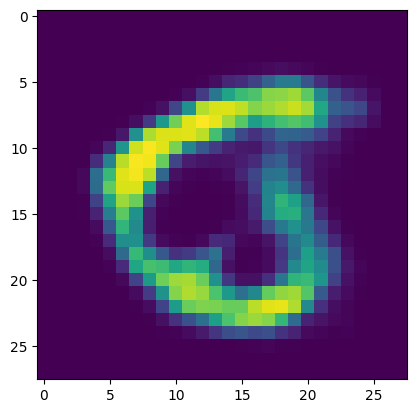

In [113]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 10) for i in range(10)])
output = model.decode(torch.tensor(z).float()).view(-1, 1, 28, 28)
output = output[0].permute(1, 2, 0).detach().numpy()
plt.imshow(output)
# output.shape

__Congrats v2.0!__